In [1]:
import os
import glob
import json
import csv
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import xml.etree.ElementTree as et
from PIL import Image
import cv2
import random

from skimage.feature import hog
from skimage import data, exposure

# for reading and displaying images
from skimage.io import imread
%matplotlib inline

import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# PyTorch libraries and modules
import torch
import torchvision

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


In [30]:
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = et.parse(xml_file)
        root = tree.getroot()
        value = (int(root.find('ObservationId').text),
                 int(root.find('MediaId').text),
                 float(root.find('Vote').text),
                 root.find('Content').text,
                 int(root.find('ClassId').text),
                 root.find('Family').text,
                 root.find('Genus').text,
                 root.find('Species').text,
                 root.find('Location').text,
                 root.find('Date').text
                 )
        xml_list.append(value)
    column_name = ['ObservationId', 'MediaId', 'Vote', 'Content', 'ClassId', 'Family', 'Genus', 'Species','Location','Date']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():
    image_path = os.path.join(os.getcwd(), 'small_dataset_train/train')
    xml_df = xml_to_csv(image_path)
    xml_df.to_csv('flowers.csv', index=None)
    print('Successfully converted xml to csv.')


main()

Successfully converted xml to csv.


In [2]:
df = pd.read_csv('flowers.csv')
df.head()

,ObservationId,MediaId,Vote,Content,ClassId,Family,Genus,Species,Location,Date
0,9539,95266,2.0,Flower,588,Asteraceae,Centaurea,Centaurea jacea L.,Les Assions,2011-6-3
1,19569,12606,3.0,Flower,2394,Cistaceae,Cistus,Cistus albidus L.,Cabrespine,2011-7-15
2,41243,2514,4.0,Flower,4516,Ranunculaceae,Ficaria,Ficaria verna Huds.,NaN,2014-3-20
3,10219,54452,4.0,Flower,4436,Ranunculaceae,Clematis,Clematis vitalba L.,Feugarolles,2013-7-21
4,12133,82344,3.0,Flower,8708,Apiaceae,Astrantia,Astrantia major L.,Suc-et-Sentenac,2009-7-28


In [32]:
di = {"Papaver rhoeas L.": 1,"Cichorium intybus L.": 2,
      "Ophrys apifera Huds.": 3,"Bellis perennis L.": 4,
      "Daucus carota L.": 5,"Orchis purpurea Huds.": 6,
      "Ophrys scolopax Cav.": 7,"Salix caprea L.": 8,
      "Anacamptis pyramidalis (L.) Rich.": 9,"Dactylorhiza maculata (L.) Soó": 10,
      "Hypochaeris radicata L.": 11,"Ophrys aranifera Huds.": 12,
      "Himantoglossum robertianum (Loisel.) P.Delforge": 13,"Ficaria verna Huds.": 14,
      "Aquilegia vulgaris L.": 15,"Cypripedium calceolus L.": 16,
      "Glaucium flavum Crantz": 17,"Orchis mascula (L.) L.": 18,
      "Himantoglossum hircinum (L.) Spreng.": 19,"Urospermum dalechampii (L.) Scop. ex F.W.Schmidt": 20,
      "Cistus albidus L.": 21,"Ophrys lutea Cav.": 22,
      "Epipactis helleborine (L.) Crantz": 23,"Eupatorium cannabinum L.": 24,
      "Centaurea jacea L.": 25,"Tulipa sylvestris L.": 26,
      "Cyanus segetum Hill": 27,"Centaurea aspera L.": 28,
      "Primula veris L.": 29,"Achillea millefolium L.": 30,
      "Aconitum napellus L.": 31,"Chelidonium majus L.": 32,
      "Cirsium vulgare (Savi) Ten.": 33,"Viola tricolor L.": 34,
      "Primula vulgaris Huds.": 35,"Astrantia major L.": 36,
      "Orchis anthropophora (L.) All.": 37,"Anemone nemorosa L.": 38,
      "Clematis vitalba L.": 39,"Ophrys virescens Philippe": 40,
      "Dactylorhiza fuchsii (Druce) Soó": 41,"Serapias vomeracea (Burm.f.) Briq.": 42,
      "Anemone hepatica L.": 43,"Anemone alpina L.": 44,
      "Ophrys passionis Sennen": 45,"Leucanthemum vulgare Lam.": 46,
      "Ilex aquifolium L.": 47,"Anacamptis morio (L.) R.M.Bateman, Pridgeon & M.W.Chase": 48,
      "Epipactis atrorubens (Hoffm.) Besser": 49,"Helianthemum nummularium (L.) Mill.": 50}

In [9]:
df2 = df.copy()
df2["Species"].replace(di, inplace=True)

In [10]:
df2['Species'].value_counts()

1     119
2     109
3     108
4      97
5      95
6      94
7      90
8      88
9      85
10     85
11     84
12     83
13     81
14     77
15     75
16     75
18     74
17     74
19     73
20     70
21     69
23     68
22     68
24     67
25     66
26     66
28     65
27     65
29     63
30     62
31     61
32     60
33     58
34     57
37     56
36     56
35     56
38     55
40     55
39     55
41     54
42     53
45     52
44     52
43     52
46     51
47     51
48     49
49     48
50     48
Name: Species, dtype: int64

In [3]:
def loadImages():
    # Put files into lists and return them as one list of size 4
    image_path = os.path.join(os.getcwd(), 'small_dataset_train/train')
    image_files = [os.path.join(image_path, file)
         for file in os.listdir(image_path) if      file.endswith('.jpg')]
    
    return image_files

data_images = loadImages()

In [8]:
def processing(dataI):
    for i in dataI:
        img = Image.open(i)      
        temp= i.split('.')
        new_image = img.resize((150, 150))    
        greyscale_image = new_image.convert('L')
       # croppedIm = greyscale_image.crop((290, 250, 650, 650)) 
        name = str(temp[0])+'.png'       
       # croppedIm.save(name)
        greyscale_image.save(name)
        
processing(data_images)

In [3]:
# loading training images
train_img = []
for img_name in tqdm(df['MediaId']):
    # defining the image path
    image_path = os.path.join(os.getcwd(), 'small_dataset_train/train/') + str(img_name) + '.png'
    # reading the image
    img = imread(image_path, as_gray=True)
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)

# converting the list to numpy array
train_x = np.array(train_img)
# defining the target
train_y = df[['Species']].values.ravel()
train_x.shape

100%|██████████| 3474/3474 [00:33<00:00, 103.31it/s]


(3474, 150, 150)

In [4]:
# Integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(train_y)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
train_y = onehot_encoder.fit_transform(integer_encoded)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f7730570908>,
 <matplotlib.image.AxesImage at 0x7f77304de6a0>)

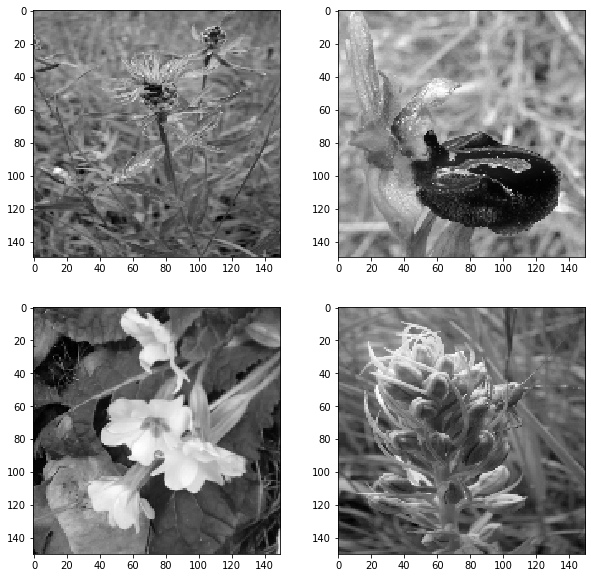

In [5]:
# visualizing images
i = 0
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_x[i], cmap='gray')
plt.subplot(222), plt.imshow(train_x[i+25], cmap='gray')
plt.subplot(223), plt.imshow(train_x[i+50], cmap='gray')
plt.subplot(224), plt.imshow(train_x[i+75], cmap='gray')

In [6]:
# 10% create validation set
train_x, val_x, train_y, val_y = train_test_split(
    train_x, 
    train_y, 
    test_size = 0.1)

(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((3126, 150, 150), (3126, 50)), ((348, 150, 150), (348, 50)))

In [7]:
# converting training images into torch format
train_x = train_x.reshape(3126, 1, 150, 150)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(int);
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([3126, 1, 150, 150]), torch.Size([3126, 50]))

In [8]:
# converting validation images into torch format
val_x = val_x.reshape(348, 1, 150, 150)
val_x = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(int);
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([348, 1, 150, 150]), torch.Size([348, 50]))

In [9]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(5476, 50)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [10]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=5476, out_features=50, bias=True)
  )
)


In [11]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)
    
    # computing the training and validation loss
    loss_train = criterion(output_train, torch.max(y_train, 1)[1])
    loss_val = criterion(output_val, torch.max(y_val, 1)[1])
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    # printing the validation loss
    print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [ ]:
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : tensor(4.0509, grad_fn=<NllLossBackward>)
Epoch :  2 	 loss : tensor(123.3025, grad_fn=<NllLossBackward>)
Epoch :  3 	 loss : tensor(145.3549, grad_fn=<NllLossBackward>)
Epoch :  4 	 loss : tensor(141.7793, grad_fn=<NllLossBackward>)
Epoch :  5 	 loss : tensor(118.1905, grad_fn=<NllLossBackward>)
Epoch :  6 	 loss : tensor(72.2588, grad_fn=<NllLossBackward>)
Epoch :  7 	 loss : tensor(16.1950, grad_fn=<NllLossBackward>)
Epoch :  8 	 loss : tensor(3.9196, grad_fn=<NllLossBackward>)
Epoch :  9 	 loss : tensor(3.9241, grad_fn=<NllLossBackward>)
Epoch :  10 	 loss : tensor(3.9279, grad_fn=<NllLossBackward>)
Epoch :  11 	 loss : tensor(3.9308, grad_fn=<NllLossBackward>)
Epoch :  12 	 loss : tensor(3.9327, grad_fn=<NllLossBackward>)
Epoch :  13 	 loss : tensor(3.9339, grad_fn=<NllLossBackward>)
Epoch :  14 	 loss : tensor(3.9342, grad_fn=<NllLossBackward>)
Epoch :  15 	 loss : tensor(3.9338, grad_fn=<NllLossBackward>)
Epoch :  16 	 loss : tensor(3.9328, grad_fn=<NllLossBa